# Text to Speech



![this should be a picture](https://i.imgur.com/WQXFdci.png)

Last week was all about sound processing: you learned about audio files, spectrograms and even trained a simple speech classifier on top of that. This time we'll do the same, but the other way around: the should take text as an input and generate sound from that. Jump in! it's gonna be fun :)

In [ ]:
import json
import glob
import numpy as np
import random

## Data
We took LJSpeech and carefully extracted features (Mels-specs and phone alignment) so you don't have to.


In [ ]:
!pip install librosa tensorflow-gpu==2.1.0c0
!wget https://www.dropbox.com/s/fmvi648spv8xjxd/cmudict.dict?dl=1 -O cmudict.dict
!wget https://www.dropbox.com/s/ihhs20xws1jstvu/dataset-aligned.tar?dl=1 -O dataset-aligned.tar
!wget https://www.dropbox.com/s/zvyqz4ovx84gaw1/waveglow_256channels.pt?dl=1 -O waveglow_256channels.pt
!tar -xf dataset-aligned.tar

In [ ]:
all_rows = [
    json.load(open(fname, encoding='utf8'))
    for fname in glob.glob('dataset-aligned/*.json')
]
assert len(all_rows) == 13100

id2utt = {row['ID']: row['utterance'] for row in all_rows if 'utterance' in row}

all_ids = sorted(id2utt.keys())
assert len(id2utt) == 13071

NMels = 80

id2mel = {
    ID: np.load('dataset-aligned/{}.mel.npy'.format(ID))
    for ID in id2utt
}
for mels in id2mel.values():
    assert mels.shape[0] == NMels


## What is in an utterance?

In [ ]:
id2utt[all_ids[1231]]

{'words': [{'text': 'the',
   'phones': [{'duration': 30, 'ext_phone': 'DH_B', 'onset': 0, 'phone': 'DH'},
    {'duration': 40, 'ext_phone': 'AH0_E', 'onset': 30, 'phone': 'AH0'}]},
  {'text': 'commission',
   'phones': [{'duration': 100, 'ext_phone': 'K_B', 'onset': 70, 'phone': 'K'},
    {'duration': 40, 'ext_phone': 'AH0_I', 'onset': 170, 'phone': 'AH0'},
    {'duration': 70, 'ext_phone': 'M_I', 'onset': 210, 'phone': 'M'},
    {'duration': 70, 'ext_phone': 'IH1_I', 'onset': 280, 'phone': 'IH1'},
    {'duration': 120, 'ext_phone': 'SH_I', 'onset': 350, 'phone': 'SH'},
    {'duration': 40, 'ext_phone': 'AH0_I', 'onset': 470, 'phone': 'AH0'},
    {'duration': 140, 'ext_phone': 'N_E', 'onset': 510, 'phone': 'N'}]},
  {'text': 'urges',
   'phones': [{'duration': 70,
     'ext_phone': 'EU1_B',
     'onset': 650,
     'phone': 'EU1'},
    {'duration': 120, 'ext_phone': 'R_I', 'onset': 720, 'phone': 'R'},
    {'duration': 90, 'ext_phone': 'JH_I', 'onset': 840, 'phone': 'JH'},
    {'duratio

on the other hand PAUSE , those plants , such as the fungi ,


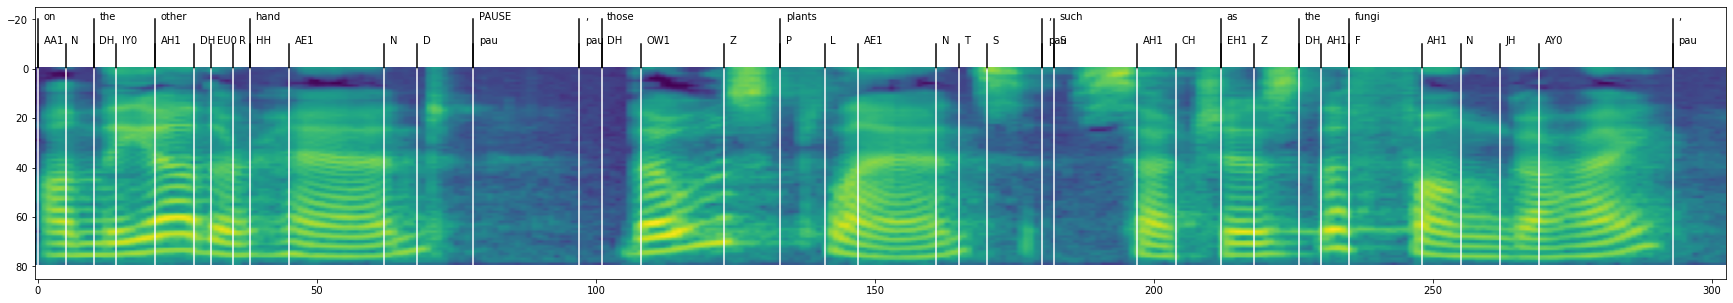

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def ms2frames(ms, SR=22050, hop_length = 256):
    return int(ms / 1000 * SR / hop_length)

def show_utt(utt, mels, contour=False):
    print(' '.join(w['text'] for w in utt['words']).replace('yandexttsspecialpauseword', 'PAUSE'))
    plt.figure(figsize=[mels.shape[1] / 10, 5])
    plt.imshow(mels[::-1], aspect='auto')
    if contour:
        plt.contour(mels[::-1], levels = 5,colors='w')
    for word in utt['words']:
        onset = ms2frames(word['phones'][0]['onset'])
        plt.text(onset + 1, -20, word['text'].replace('yandexttsspecialpauseword', 'PAUSE'))
        plt.plot([onset] * 2, [-20, 0], 'k')
        for phone in word['phones']:
            onset = ms2frames(phone['onset'])
            plt.text(onset + 1, -10, phone['phone'])
            plt.plot([onset] * 2, [-10, 0], 'k')
            plt.plot([onset] * 2, [80, 0], 'w')
    plt.show()
    
ID = all_ids[45]
show_utt(id2utt[ID], id2mel[ID])


## Listen
We'll use a pre-trained Waveglow vocoder:
https://github.com/NVIDIA/waveglow

It's written in PyTorch. If you need to install it locally, [here](https://pytorch.org/)'s how you do that.

In [ ]:
!git clone https://github.com/NVIDIA/tacotron2.git
!cd tacotron2 && git submodule update --init

Cloning into 'tacotron2'...
remote: Enumerating objects: 409, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 409 (delta 1), reused 2 (delta 0), pack-reused 403
Receiving objects: 100% (409/409), 2.70 MiB | 15.77 MiB/s, done.
Resolving deltas: 100% (205/205), done.
Submodule 'waveglow' (https://github.com/NVIDIA/waveglow) registered for path 'waveglow'
Cloning into '/content/tacotron2/waveglow'...
Submodule path 'waveglow': checked out '5bc2a53e20b3b533362f974cfa1ea0267ae1c2b1'


In [ ]:
!wget 'https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ljs_256channels/versions/3/files/waveglow_256channels_ljs_v3.pt'

--2022-10-03 16:20:49--  https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ljs_256channels/versions/3/files/waveglow_256channels_ljs_v3.pt
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 52.24.193.40, 54.68.189.169
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|52.24.193.40|:443... connected.
HTTP request sent, awaiting response... 302 
Location: https://prod-model-registry-ngc-bucket.s3.us-west-2.amazonaws.com/org/nvidia/models/waveglow_ljs_256channels/versions/3/files/waveglow_256channels_ljs_v3.pt?response-content-disposition=attachment%3B%20filename%3D%22waveglow_256channels_ljs_v3.pt%22&response-content-type=application%2Foctet-stream&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEPD%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLXdlc3QtMiJHMEUCIHHGOgWFxV6Nc2rhxNw1H0bWPXkv4QJyLQcSYfnNUJ3xAiEAnqXKGFSQaG6sDB%2F86vSHYUEG6uspm6PRC2Dc9RHG%2BP0q1QQIqf%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FARAEGgw3ODkzNjMxMzUwMjciDIS7%2FRBigoiQHBPfzSqpBEkJte5tumzUapw0P09hQ%2BcXK1op%2BtsfTh8Zz4e1G%2FGQSsLJDBtLa3gs7laR

In [ ]:
#!python /content/tacotron2/waveglow/convert_model.py waveglow_256channels.pt waveglow_256channels_new.pt

In [ ]:
!pwd

/content


In [ ]:
## Import and load model
import torch
import sys
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch_device == 'cpu':
  torch.cuda.FloatTensor = torch.FloatTensor  # dirty trick to run old WaveGlow

WGP = 'tacotron2/waveglow/'
if WGP not in sys.path:
    sys.path.append(WGP)

waveglow_path = 'waveglow_256channels_ljs_v3.pt'
waveglow = torch.load(waveglow_path, map_location=torch_device)['model']
waveglow.to(torch_device).train(False)
if torch_device == 'cuda':
    waveglow = waveglow.half()
    for k in waveglow.convinv:
        k.float()

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

In [ ]:
## Synthesize and listen
## Don't mind the warnings, it's an old model checkpoint
import IPython.display as ipd
def synthesize(mels, SR=22050):
    with torch.no_grad():
        torch_batch = torch.as_tensor(
            mels[None, :, :], device=torch_device, 
            dtype=torch.float16 if torch_device=='cuda' else torch.float32)
        audio = waveglow.infer(torch_batch, sigma=1)
    ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=SR, autoplay=True))


synthesize(id2mel[all_ids[32]])

## Build phoneme dictionary (the usual)

In [ ]:
from collections import Counter
phone_counts = Counter(
    phone['phone'] 
    for utt in id2utt.values() 
    for word in utt['words'] 
    for phone in word['phones']
)
PAD = '_PAD'

In [ ]:
phone_counts

In [ ]:
from collections import Counter
phone_counts = Counter(
    phone['phone'] 
    for utt in id2utt.values() 
    for word in utt['words'] 
    for phone in word['phones']
)
PAD = '_PAD'

# Task: create phoneme vocabulary that maps phonemes to ids
# Note: your words should be sorted by python string order
all_phones = sorted(phone_counts.keys()) + [PAD]
phone2idx = {ph: idx for idx, ph in enumerate(all_phones)}
assert len(all_phones) == 55
assert all_phones[-1] == PAD
assert phone2idx[all_phones[0]] == 0
assert phone2idx[all_phones[13]] == 13
assert phone2idx[all_phones[-1]] == 54

print('All good!')

## Let's look at data:
### Phone durations histogram

In [ ]:
all_durations = np.array([phone['duration'] for utt in id2utt.values() for word in utt['words'] for phone in word['phones']])
plt.hist(all_durations, bins=100, log=True)
plt.show()
print('mean={}'.format(np.mean(all_durations)))
print('median={}'.format(np.median(all_durations)))

### Sentence lengths in frames and in phones:


In [ ]:
#sent lengths in frames and in phones:

phone_counts = [sum(len(word['phones']) for word in utt['words']) for utt in id2utt.values()]
frame_counts = [mels.shape[1] for mels in id2mel.values()]

plt.figure(figsize=[10,10])
plt.subplot(2,2,1)
plt.hist(phone_counts, bins=30)
plt.subplot(2,2,2)
plt.plot(sorted(phone_counts))

plt.subplot(2,2,3)
plt.hist(frame_counts, bins=30)
plt.subplot(2,2,4)
plt.plot(sorted(frame_counts))
plt.show()


### Melspec distributions

In [ ]:
some_mels = np.concatenate([id2mel[ID] for ID in random.sample(all_ids, 100)], axis=1)

mel_means = np.mean(some_mels, axis=1)
mel_stds = np.std(some_mels, axis=1)

plt.plot(mel_means, label='mean')
plt.plot(mel_means + mel_stds, label = 'mean + std')
plt.plot(mel_means - mel_stds, label = 'mean - std')
plt.plot(mel_stds, label = 'std')
plt.legend()
plt.show()

mel_corr = np.corrcoef(some_mels)
plt.imshow(mel_corr)
plt.show()



## Generating batches

In [ ]:
from collections import namedtuple

TtsBatch = namedtuple('TtsBatch', [
    'phone_idxs', # (B x Lenc), int
    'phone_durs', # (B x Lenc), float
    'alignment',  # (B x Ldec), int
    'mels',       # (B x Ldec x Nmels), float
])

In [ ]:
def gen_batch(ids):
    """ Assemble training batch from sample indices """
    utts = [id2utt[ID] for ID in ids]
    phone_seqs = [[phone2idx[phone['phone']] for word in utt['words'] for phone in word['phones']] for utt in utts]
    phone_durs = [[phone['duration'] for word in utt['words'] for phone in word['phones']] for utt in utts]
    phone_seq_mat = np.full([len(ids), max(map(len, phone_seqs))], phone2idx[PAD], dtype='int32')
    phone_dur_mat = np.ones([len(ids), max(map(len, phone_seqs))], dtype='float32')
    for i, (idxs, durs) in enumerate(zip(phone_seqs, phone_durs)):
        phone_seq_mat[i, :len(idxs)] = idxs
        phone_dur_mat[i, :len(idxs)] = durs
        
        
    mels = [id2mel[ID] for ID in ids]
    mel_lengths = np.array([mel.shape[1] for mel in mels], dtype='int32')
    mel_mat = np.full([len(ids), max(mel_lengths), NMels], -1, dtype='float32')
    mel_aligns = np.full([len(ids), max(mel_lengths)], -1, dtype='int32')
    for i, mel in enumerate(mels):
        mel_mat[i,  :mel_lengths[i]] = mel.T
        for j, phone in enumerate(phone for word in utts[i]['words'] for phone in word['phones']):
            start = ms2frames(phone['onset'])
            finish = ms2frames(phone['onset'] + phone['duration'])
            mel_aligns[i, start:finish] = j
    return TtsBatch(
        phone_idxs=phone_seq_mat,
        phone_durs=phone_dur_mat,
        alignment=mel_aligns,
        mels=mel_mat
    )
    
    
gen_batch(all_ids[:1])


In [ ]:
valid_ids = all_ids[:100]
train_ids = all_ids[100:]

In [ ]:
from tensorflow.python.client import device_lib

is_gpu_available = any(device.device_type == 'GPU' for device in device_lib.list_local_devices())
device = '/device:GPU:0' if is_gpu_available else '/device:CPU:0'

## Model & training __(3 points)__

In [ ]:
import tensorflow as tf
assert tf.__version__.startswith('2'), "Current tf version: {}; required: 2.0.*".format(tf.__version__)
L = tf.keras.layers
keras = tf.keras

class Model(L.Layer):
    def __init__(
        self, 
        phone_count=len(all_phones), 
        emb_size=128, 
        enc_hid_size=128, 
        dec_hid_size=128,
    ):
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.

        # Phoneme embedding
        self.emb = L.Embedding(phone_count, emb_size)
        # Encoder cell
        self.encoder = L.GRU(enc_hid_size, return_sequences=True)
        # Duration predictor
        self.dur_linear = L.Dense(
            1, bias_initializer=keras.initializers.constant(np.mean(all_durations))
            # Karpathy's trick: http://karpathy.github.io/2019/04/25/recipe/

        )
        # Decoder cell
        self.decoder = L.GRU(dec_hid_size, return_sequences=True, return_state=True)

        # Melspec predictor
        self.mel_projection = L.Dense(
            NMels, bias_initializer=keras.initializers.constant(mel_means)
        ) 
        
        self.zeroth_mel = tf.Variable(np.random.normal(size=[NMels]), dtype='float32', name='zero_mel')

    def encode(self, 
               phone_idxs, # B x Lenc
               train=False):
        # Encode phonemes and predict durations from hidden state.
        # You should use: emb, encoder, dur_linear
        X = self.emb(phone_idxs)
        Y = self.encoder(X)
        hid_state = Y
        durations = self.dur_linear(Y)
        
        return (
            durations , # B x Lenc x 1
            hid_state   # B x Lenc x Henc
        )
    

    def decode(self, 
               encoded,    # B x Lenc x Henc
               alignments, # B x Ldec
               prev_mels,  # B x Ldec x NMels
               prev_states, # None or list of RNN cell(s) states
               train=False):
        encoded_upsampled = tf.gather_nd(encoded, tf.maximum(0, alignments[:,:,None]), batch_dims=1)
        X = tf.concat([encoded_upsampled, prev_mels], axis=2)

        # Run decoder recurrent network over X. Start from prev_states
        # After that you can predict next mels using mel_projection
        Y, new_states = self.decoder(X, prev_states[0])
        mels = self.mel_projection(Y)
    
        return (
            mels,      # B x Ldec X NMels
            [new_states] # list of states
        )
    
    def forward_train(self, batch, train=False):
        # This runs the model in train mode for calculating loss + optionally gradients,
        # using teacher forcing on mels
        
        # Prepare
        zeroth_mel = tf.tile(self.zeroth_mel[None, None, :], [batch.mels.shape[0], 1, 1])
        prev_mels = tf.concat([zeroth_mel, batch.mels[:,:-1]], axis=1)
        prev_states = [None]
        
        #Run encoder
        durs, encoded = self.encode(batch.phone_idxs, train=train)
        #Run decoder
        mel_preds, _ = self.decode(encoded, batch.alignment, prev_mels, prev_states, train=train)
        
        return durs, mel_preds
    
    def forward_inference(self, 
                          phone_idx # Is flattened, doesn't work with batches
                          ):
        # This runs the model in inference mode, using its own predicted durations and mels from prev. step
        prev_mels = self.zeroth_mel[None, None, :]
        prev_states = [None]
        # Run encoder
        durs, encoded = self.encode(phone_idx.reshape([1,-1]))
        # Convert frame durations to alignments
        frame_durs = list(map(ms2frames, durs[0]))
        frame_durs = np.maximum(1, np.array(frame_durs))
        full_alignment = np.array(sum([[i] * frames for i, frames in enumerate(frame_durs)], []))
        
        # Run decoder, one step at a time, reusing previous states and mels
        result = []
        for frame_alignment in full_alignment:
            mel_preds, states = self.decode(encoded, np.full([1,1], frame_alignment), prev_mels, prev_states)
            result.append(mel_preds)
            prev_mels, prev_states = mel_preds, states
            
        # Collect mels
        mels = tf.concat(result, axis=1)
        return mels
    


In [ ]:
tf.random.set_seed(1337)
np.random.seed(1337)

model = Model()
batch = gen_batch(all_ids[78:80])
dur_pred, mel_pred = model.forward_train(batch)
assert dur_pred.shape == (2, 75, 1) 
assert mel_pred.shape ==  (2, 583, 80)
assert np.allclose(dur_pred[:,20,0].numpy(), [88.01232, 88.02252], atol=0.1, rtol=0.1)
assert np.allclose(mel_pred[0, 100, :5].numpy(), [-6.5848618, -6.194147 , -6.006989 , -4.6337852, -3.1684837], atol=0.1, rtol=0.1)


In [ ]:
mels = model.forward_inference(batch.phone_idxs)
assert mels.shape == (1, 1050, 80)
print(mels.shape)

In [ ]:
[(v.name, v.shape) for v in model.trainable_variables]

In [ ]:
def dur_loss(
    dur_true,  # B x Lenc
    dur_pred,  # B x Lenc x 1
    phone_idxs # phoneme indices B x Lenc
    ):
    mask = tf.cast(phone_idxs != phone2idx[PAD], dtype='float32') # B x Lenc

    # Evaluate Mean Absolute Error (L1) between predicted and true durations
    # Note: your should average loss only over cells where mask equals True
    pointwise = tf.abs(dur_true - dur_pred[:,:,0])
    loss = tf.reduce_sum(pointwise * mask) / tf.reduce_sum(mask)
    
    # Warning: mind the shapes! they are a bit nonintuitive

    return loss


def mel_loss(mel_true,    # B x Ldec x Nmels
             mel_pred,    # B x Ldec x Nmels
             alignments): # B x Ldec
    mask = tf.cast(alignments >= 0, dtype='float32')[:,:,None]

    # Compute Mean Squared Error (L2) between predicted and true mel spectres
    # Note: same as before, average over all active (mask) cells AND over mel channels
    Nmels = mel_pred.shape[2]
    pointwise = tf.square(mel_true - mel_pred)
    loss = tf.reduce_sum(pointwise * mask) / tf.reduce_sum(mask) / Nmels
    return loss

batch = gen_batch([all_ids[78]])
dur_pred, mel_pred = model.forward_train(batch)

loss_dur = dur_loss(batch.phone_durs, dur_pred, batch.phone_idxs)
assert loss_dur.shape == ()
assert np.allclose(loss_dur.numpy() / 30, 1.3000526, rtol=1e-2, atol=1e-2)

loss_mel = mel_loss(batch.mels, mel_pred, batch.alignment)
assert loss_mel.shape == ()
assert np.allclose(loss_mel.numpy(), 3.4176075, rtol=1e-2, atol=1e-2)


In [ ]:
with tf.device(device):
    metrics = {'train_loss': [], 'valid_loss': [] }
    model = Model()
    opt = keras.optimizers.Adam(1e-3)
    batch_size = 16

In [ ]:
valid_batch = gen_batch(valid_ids)
with tf.device(device):
    while True:
        print(end='.')
        batch = gen_batch(random.sample(train_ids, batch_size))
        step = len(metrics['train_loss']) + 1

        with tf.GradientTape() as tape:
            dur_pred, mel_pred = model.forward_train(batch)
            loss_dur = dur_loss(batch.phone_durs, dur_pred, batch.phone_idxs) / 30
            loss_mel = mel_loss(batch.mels, mel_pred, batch.alignment)
            loss_t = loss_dur / 30 + loss_mel

        grads = tape.gradient(loss_t, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))
        metrics['train_loss'].append((step, loss_t.numpy(), loss_dur.numpy(), loss_mel.numpy()))
        if step % 20 == 0:
            dur_pred, mel_pred = model.forward_train(valid_batch)
            loss_dur = dur_loss(valid_batch.phone_durs, dur_pred, valid_batch.phone_idxs) / 30
            loss_mel = mel_loss(valid_batch.mels, mel_pred, valid_batch.alignment)
            loss_v = loss_dur / 30 + loss_mel
            metrics['valid_loss'].append((step, loss_v.numpy(), loss_dur.numpy(), loss_mel.numpy()))

            ipd.clear_output(True)
            plt.figure(figsize=(12,4))
            for i, (name, history) in enumerate(sorted(metrics.items())):
                plt.subplot(1, len(metrics), i + 1)
                plt.title(name)
                history = np.array(history, dtype='float32').T
                plt.plot(history[0], history[1:].T)
                plt.grid()
                plt.legend(['total', 'duration', 'mel_pred'])
            plt.show()
            synthesized = mel_pred[0, :id2mel[valid_ids[0]].shape[1]].numpy().T
            show_utt(id2utt[valid_ids[0]], id2mel[valid_ids[0]])
            show_utt(id2utt[valid_ids[0]], synthesized)
            print("Mean loss=%.3f, valid=%.3f" % (np.mean(metrics['train_loss'][-10:], axis=0)[1], 
                                                  metrics['valid_loss'][-1][1]), flush=True)


In [ ]:
mels = model.forward_inference(valid_batch.phone_idxs[8][:36])
mels = mels.numpy()
synthesize(mels[0].T)
plt.imshow(mels[0, ::-1].T)


For Text2Speech we need a dictionary

https://github.com/cmusphinx/cmudict

In [ ]:
# Load dictionary

import collections
import re
en_g2p_dict = collections.defaultdict(list)
phone_remapping = {
    'AA0': 'AA1',
    'AA2': 'AA1',
    'AE2': 'AE1',
    'AH2': 'AH1',
    'AO2': 'AO1',
    'AW2': 'AW1',
    'AY2': 'AY1',
    'EH2': 'EH1',
    'ER0': 'EH1',
    'ER1': 'EH1',
    'ER2': 'EH1',
    'EY2': 'EY1',
    'IH2': 'IH1',
    'IY2': 'IY1',
    'OW2': 'OW1',
    'OY2': 'OY1',
    'UH2': 'UH1',
    'UW2': 'UW1',
}

with open('cmudict.dict') as f:
    for l in f:
        l = re.sub(r'#.*', '', l.strip())
        parts = l.split()
        word = parts[0]
        word = re.sub(r'\(.*\)', '', word)
        phones = parts[1:]
        phones = [phone_remapping[ph] if ph in phone_remapping else ph for ph in phones]
        assert all(ph in all_phones for ph in phones) 
        en_g2p_dict[word].append(phones)


In [ ]:
# Here you can add custom words
custom_dict = {
    'waveglow': 'W EY1 V G L OW0'.split(),
    'spartaaa': 'S P AH1 R T AH1 AH1 AH1'.split()
}
for pron in custom_dict.values():
    for ph in pron:
        assert ph in phone2idx

In [ ]:
# Preprocessor: Text -> phone indexes

from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

def preprocess(sent):
    words = tokenizer.tokenize(sent.lower())
    phones = []
    for word in words:
        if re.fullmatch(r'[^a-z]*', word):
            phones += ['pau']
        elif word in custom_dict:
            phones += custom_dict.get(word)
        elif word in en_g2p_dict:
            phones += en_g2p_dict.get(word)[0]
        else:
            raise ValueError('No transcription for word "{}""'.format(word))
    phone_idxs = [phone2idx[phone] for phone in phones]
    return phone_idxs

preprocess('My waveglow!')

In [ ]:
## Finally synthesize!

text = 'Hi, my name is slim shady'
mels = model.forward_inference(np.array(preprocess(text)))
mels = mels.numpy()[0].T
synthesize(mels)

plt.imshow(mels[::-1])


## Alternative vocoder

Below we implement a simple algorithmic vocoder from pre-wavenet era
Feel free to try it and see find out which works best for you :)


In [ ]:
import scipy.signal as dsp
import librosa.filters as filters
import scipy.interpolate as interp
mel_filters = filters.mel(22050, 1024, fmin=0, fmax=8000, n_mels=NMels)
mel_inv = np.linalg.pinv(mel_filters)

def robot_synth(mels, speed=1., spectr_deform=1.):
    assert mels.shape[0] == 80 and mels.ndim == 2
    spectr = np.exp(mels).T @ mel_inv.T
    phase = np.random.uniform(0, 1, size=[1,513])
    spectr = spectr * np.exp(2j * np.pi * phase)
    _, waveform = dsp.istft(spectr.T, nperseg=1024, noverlap=int(1024 - (256 / speed)))
    ipd.display(ipd.Audio(data=waveform, rate=22050, autoplay=True))
    

robot_synth(mels[0].T, speed=0.7)